In [1]:
import pandas as pd
from collections import Counter
import collections
import os
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from tqdm.auto import tqdm

In [2]:
use_col=['twitter', 'parler']
match_user=pd.read_csv('/Users/mstudio/Library/CloudStorage/Box-Box/us_election_2020/Jay-toxicity/parallel-results/parallel-results-mac-95.csv', usecols=use_col)
match_user.columns=['twitter', 'parler']

In [3]:
print("Number of unique Twitter users: ", len(match_user['twitter'].unique()))
print("Number of unique Parler users: ", len(match_user['parler'].unique()))

Number of unique Twitter users:  13644
Number of unique Parler users:  13016


In [4]:
print("Average Parler accounts matched to one Twitter account: ", match_user.groupby('twitter').count().sort_values(by='parler', ascending=False).mean().values[0])
print("Average Twitter accounts matched to one Parler account: ", match_user.groupby('parler').count().sort_values(by='twitter', ascending=False).mean().values[0])

Average Parler accounts matched to one Twitter account:  1.0047639988273234
Average Twitter accounts matched to one Parler account:  1.0532421634910878


Twitter

In [5]:
data_list=[]
for file in tqdm(os.listdir('/Users/mstudio/Library/CloudStorage/Box-Box/us_election_2020/Jay-toxicity/twitter_all'), desc='Loading Twitter data'):
    if file.endswith('.csv'):
        name_file='rr-toxicity-rr-'+file
        data=pd.read_csv('/Users/mstudio/Library/CloudStorage/Box-Box/us_election_2020/Jay-toxicity/revise_and_revision/rr_toxicity_twitter/'+name_file, usecols=['lower_username', 'tweet', 'toxicity'])
        data_list.append(data)

Loading Twitter data:   0%|          | 0/47 [00:00<?, ?it/s]

In [6]:
frame=pd.concat(data_list, axis=0, ignore_index=True)

In [7]:
frame.shape

(1558956, 3)

In [8]:
frame['interact']=frame['tweet'].str.findall(r'(@[^\s]+)').str.join(' ').str.replace(':', '').str.replace('@', '').str.lower()
frame['interact']=frame['interact'].str.split(" ")
frame['interact']=[','.join(map(str, l)) for l in frame['interact']]

In [9]:
df_explode=frame.assign(interact=frame.interact.str.split(",")).explode('interact')

In [10]:
df_explode.shape

(2164670, 4)

In [11]:
match_user.shape

(13709, 2)

In [10]:
df_explode=df_explode.reset_index(drop=True)

In [12]:
outgroup_dic_tweet={}
outgroup_dic_tweet_count={}
for i in tqdm(range(0, len(df_explode.lower_username.unique())-1)): 
    ingroup_tox_tweet=[]
    outgroup_tox_tweet=[]
    user=df_explode['lower_username'][i]
    df=df_explode[df_explode['lower_username']==user]
    outgroupdf=df[(df['lower_username'].isin(match_user['twitter']))&(~df['interact'].isin(match_user['twitter']))]
    try:
        outgroup_dic_tweet[user]=(sum(outgroupdf['toxicity'])/len(outgroupdf['toxicity']))
        outgroup_dic_tweet_count[user]=len(outgroupdf['toxicity'])
    except ZeroDivisionError:
        outgroup_dic_tweet[user]=0
        outgroup_dic_tweet_count[user]=0 

  0%|          | 0/38797 [00:00<?, ?it/s]

In [13]:
print(len(outgroup_dic_tweet))

6361


In [14]:
#get rid of keys if the values are 0
# ingroup_dic_tweet2={k:v for k, v in ingroup_dic_tweet.items() if v!=0}
outgroup_dic_tweet2={k:v for k, v in outgroup_dic_tweet.items() if v!=0}

Parler

In [15]:
data_list_parler=[]
for file in tqdm(os.listdir('/Users/mstudio/Library/CloudStorage/Box-Box/us_election_2020/Jay-toxicity/parler_all'), desc='Loading Parler data'):
    if file.endswith('.csv'):
        name_file='rr-toxicity-rr-'+file
        data=pd.read_csv('/Users/mstudio/Library/CloudStorage/Box-Box/us_election_2020/Jay-toxicity/revise_and_revision/rr_toxicity_parler/'+name_file, usecols=['lower_username', 'body', 'toxicity'])
        data_list_parler.append(data)

Loading Parler data:   0%|          | 0/47 [00:00<?, ?it/s]

In [16]:
frame_parler=pd.concat(data_list_parler, axis=0, ignore_index=True)

In [17]:
frame_parler.shape

(107280, 3)

In [18]:
frame_parler['interact']=frame_parler['body'].str.findall(r'(@[^\s]+)').str.join(' ').str.replace(':', '').str.replace('@', '').str.lower()
frame_parler['interact']=frame_parler['interact'].str.split(" ")
frame_parler['interact']=[','.join(map(str, l)) for l in frame_parler['interact']]

In [19]:
df_explode_parler=frame_parler.assign(interact=frame_parler.interact.str.split(",")).explode('interact')

In [21]:
df_explode_parler.shape

(114324, 4)

In [20]:
df_explode_parler=df_explode_parler.reset_index(drop=True)

In [22]:
ingroup_dic_parley={}
ingroup_dic_parley_count={}
for i in tqdm(range(0, len(df_explode_parler.lower_username.unique())-1)):
    ingroup_tox_parley=[]
    outgroup_tox_parley=[]
    user=df_explode_parler['lower_username'][i]
    df=df_explode_parler[df_explode_parler['lower_username']==user]
    ingroupdf=df[df['lower_username'].isin(match_user['parler'])]
    try:
        ingroup_dic_parley[user]=(sum(ingroupdf['toxicity'])/len(ingroupdf['toxicity']))
        ingroup_dic_parley_count[user]=len(ingroupdf['toxicity'])
    except ZeroDivisionError:
        outgroup_dic_tweet[user]=0
        outgroup_dic_tweet_count[user]=0 

  0%|          | 0/29752 [00:00<?, ?it/s]

In [23]:
#get rid of keys if the values are 0
ingroup_dic_parley2={k:v for k, v in ingroup_dic_parley.items() if v!=0}
# outgroup_dic_parler2={k:v for k, v in outgroup_dic_parler.items() if v!=0}

In [24]:
print(len(outgroup_dic_tweet2), len(ingroup_dic_parley2))

3323 5400


In [25]:
ground_ingroup_parler = {k: ingroup_dic_parley2[k] for k in ingroup_dic_parley2 if k in outgroup_dic_tweet2}
ground_outgroup_tweet = {k: outgroup_dic_tweet2[k] for k in ground_ingroup_parler if k in ground_ingroup_parler}

In [26]:
print(len(ground_ingroup_parler), len(ground_outgroup_tweet))

1127 1127


In [27]:
ground_outgroup_tweet_count = {k: outgroup_dic_tweet_count[k] for k in outgroup_dic_tweet_count if k in outgroup_dic_tweet2}
ground_ingroup_parler_count = {k: ingroup_dic_parley_count[k] for k in ingroup_dic_parley_count if k in ground_outgroup_tweet}
print(len(ground_ingroup_parler_count), len(ground_outgroup_tweet_count))

1127 3323


Visualization

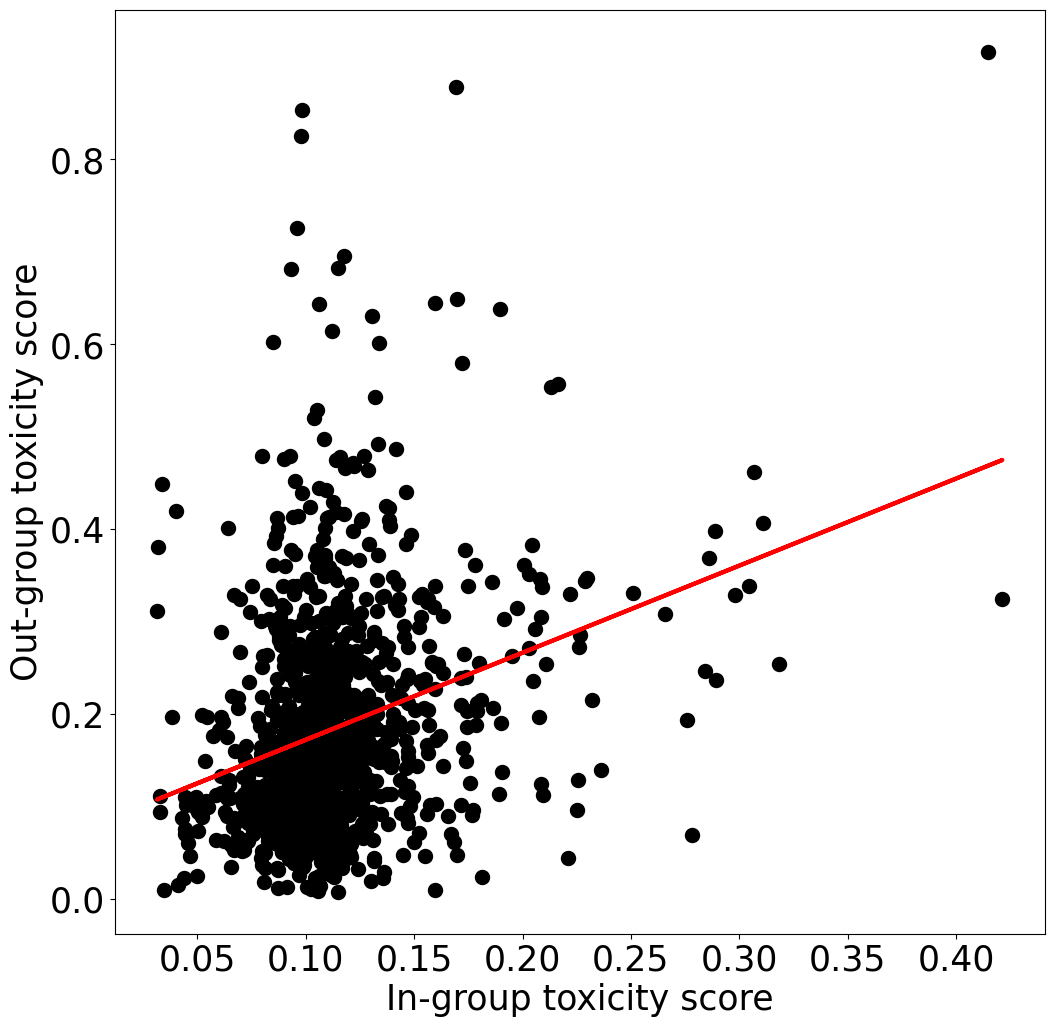

In [29]:
import matplotlib.pyplot as plt
x=ground_outgroup_tweet.values()
y=ground_ingroup_parler.values()
z=ground_ingroup_parler_count.values()
k=ground_outgroup_tweet_count.values()
# x1=ground_ingroup_parler.values()
# y1=ground_outgroup_parler.values()
z1=ground_ingroup_parler_count.values()
k1=ground_outgroup_tweet_count.values()

linear_regressor = LinearRegression()
# linear_regressor1 = LinearRegression()  # create object for the class
linear_regressor.fit(np.array(list(x)).reshape(-1, 1), np.array(list(y)).reshape(-1, 1))  # perform linear regression
# linear_regressor1.fit(np.array(list(x1)).reshape(-1, 1), np.array(list(y1)).reshape(-1, 1))
Y_pred = linear_regressor.predict(np.array(list(x)).reshape(-1, 1))  # make predictions
# Y_pred1 = linear_regressor1.predict(np.array(list(x1)).reshape(-1, 1))

fig = plt.figure(figsize=(12,12))
plt.scatter(x, y, color='black', s=50, marker='o', linewidths=4) #tweet
# plt.scatter(x1, y1, color='red', s=50, marker='x', linewidths=2) #parler
plt.xlabel('In-group toxicity score', fontsize=25)
plt.ylabel('Out-group toxicity score', fontsize=25)
# plt.legend(['Twitter', 'Parler'], fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.plot(x, Y_pred, color='red', linewidth=3)
# plt.plot(x1, Y_pred1, color='blue', linewidth=3)
# plt.savefig('sage_latex_template_4/figure/RQ1rr-test-fontsize15-95-new.pdf', bbox_inches='tight', dpi=300)
# plt.savefig('figure/RQ1rr-test-fontsize15-95-new.pdf', bbox_inches='tight', dpi=300)
plt.show()

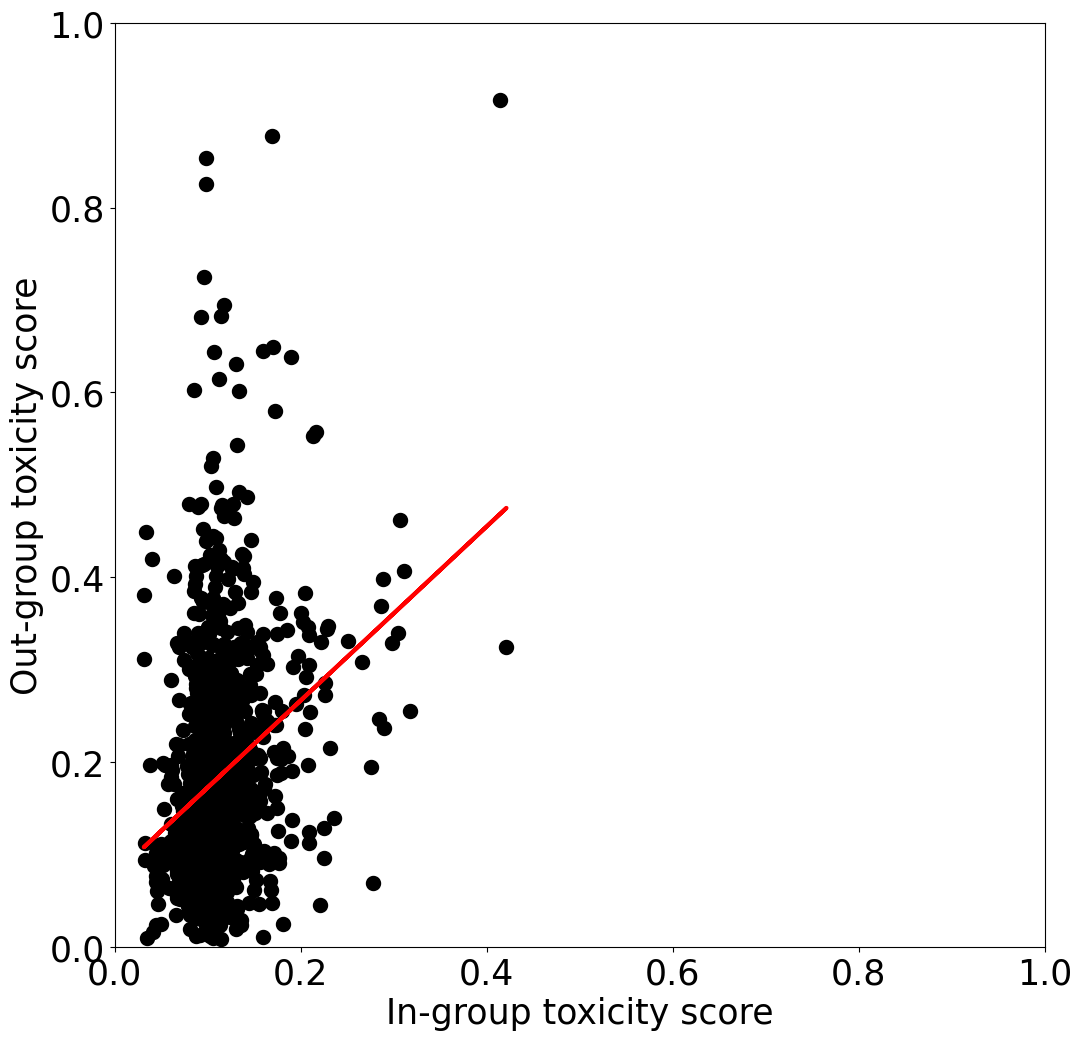

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Your data (x and y values)
x = ground_outgroup_tweet.values()
y = ground_ingroup_parler.values()

# Create a linear regression model
linear_regressor = LinearRegression()
linear_regressor.fit(np.array(list(x)).reshape(-1, 1), np.array(list(y)).reshape(-1, 1))
Y_pred = linear_regressor.predict(np.array(list(x)).reshape(-1, 1))

# Create a square figure

fig = plt.figure(figsize=(12,12))
# fig = plt.figure(figsize=(6, 6))

# Set the aspect ratio to be equal
# plt.gca().set_aspect('equal')#, adjustable='box')

# Scatter plot your data points
plt.scatter(x, y, color='black', s=50, marker='o', linewidths=4)

plt.plot(x, Y_pred, color='red', linewidth=3)

# Customize labels, legend, and fonts
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('In-group toxicity score', fontsize=25)
plt.ylabel('Out-group toxicity score', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

# Save and show the plot
# plt.savefig('sage_latex_template_4/figure/RQ1rr-test-fontsize15-95-new.pdf', bbox_inches='tight', dpi=300)
# plt.savefig('figure/RQ1rr-test-fontsize15-95-new.pdf', bbox_inches='tight', dpi=300)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Your data (x and y values)
x = ground_outgroup_tweet.values()
y = ground_ingroup_parler.values()

# Create a linear regression model
linear_regressor = LinearRegression()
linear_regressor.fit(np.array(list(x)).reshape(-1, 1), np.array(list(y)).reshape(-1, 1))
Y_pred = linear_regressor.predict(np.array(list(x)).reshape(-1, 1))

# Create a square figure
fig = plt.figure(figsize=(6, 6))

# Set the aspect ratio to be equal
plt.gca().set_aspect('equal', adjustable='box')

# Scatter plot your data points
plt.scatter(x, y, color='black', s=50, marker='o', linewidths=4)
plt.plot(x, Y_pred, color='red', linewidth=3)

# Customize labels, legend, and fonts
plt.xlabel('In-group toxicity score', fontsize=12)
plt.ylabel('Out-group toxicity score', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Save and show the plot
plt.savefig('sage_latex_template_4/figure/RQ1rr-test-fontsize15-95-new.pdf', bbox_inches='tight', dpi=300)
plt.savefig('figure/RQ1rr-test-fontsize15-95-new.pdf', bbox_inches='tight', dpi=300)
plt.show()


In [43]:
import statsmodels.formula.api as sm

In [30]:
data=pd.DataFrame(list(zip(x, y, z, k)), columns=['ground_ingroup_parler', 'ground_outgroup_twitter', 'ground_ingroup_count', 'ground_outgroup_count'])

In [31]:
data.reset_index(inplace=True)
data['index']=data['index']+1

In [33]:
data.to_csv('rq2-95.csv', index=False)

In [56]:
result = sm.ols(formula="ground_outgroup_twitter ~ ground_ingroup_parler+ground_ingroup_count+ground_outgroup_count", data=data).fit()
print(result.summary())

                               OLS Regression Results                              
Dep. Variable:     ground_outgroup_twitter   R-squared:                       0.088
Model:                                 OLS   Adj. R-squared:                  0.086
Method:                      Least Squares   F-statistic:                     36.34
Date:                     Thu, 21 Sep 2023   Prob (F-statistic):           2.06e-22
Time:                             16:30:42   Log-Likelihood:                 830.16
No. Observations:                     1127   AIC:                            -1652.
Df Residuals:                         1123   BIC:                            -1632.
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

In [57]:
data

,index,ground_ingroup_parler,ground_outgroup_twitter,ground_ingroup_count,ground_outgroup_count
0,1,0.044501,0.070083,25,283
1,2,0.081276,0.115686,9,203
2,3,0.154274,0.231368,8,1447
3,4,0.096325,0.093894,80,997
4,5,0.106718,0.105279,26,619
...,...,...,...,...,...
1122,1123,0.090901,0.175036,5,77
1123,1124,0.101806,0.337962,2,828
1124,1125,0.076814,0.100855,122,198
1125,1126,0.116710,0.234514,1,652


In [58]:
data['ground_ingroup_parler'].mean()

0.11241015959358966

In [60]:
data['ground_outgroup_twitter'].mean()

0.1840003050117406